# Notebook 3 – Explainability in Anomaly Detection  
*Generated 2025-05-13*

This notebook complements **Slides 28‑33**, focusing on why & how to explain anomaly‑detection models using **SHAP**.

> Goal: move beyond *black‑box* scores to interpretable, actionable insights.

## 1️⃣ Why Explainability?

| Motivation | Example |
|------------|---------|
| **Trust** | Security analyst accepts alert if rationale makes sense. |
| **Actionability** | Pinpoint which feature (e.g., IP range) to block. |
| **Model improvement** | Spot spurious correlations driving false positives. |
| **Regulatory** | GDPR “right to explanation” for automated decisions. |


> **Colab Tip**: First run `!pip install shap -q` if SHAP is not pre‑installed.


In [34]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, callbacks
import warnings, os
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (6,4)


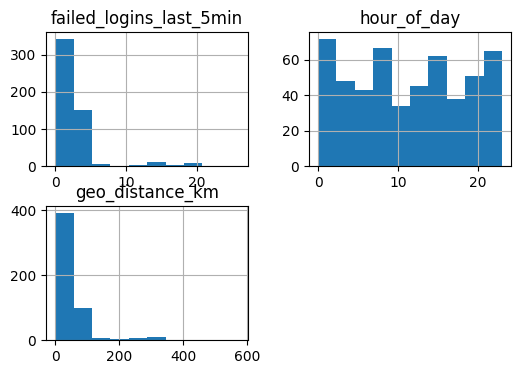

In [35]:
# Create synthetic 'login attempt' dataset
np.random.seed(42)
n_normal = 500
n_anom = 25

normal = pd.DataFrame({
    "failed_logins_last_5min": np.random.poisson(2, n_normal),
    "hour_of_day": np.random.randint(0, 24, n_normal),
    "geo_distance_km": np.random.gamma(2, 20, n_normal)  # distance from usual location
})

anom = pd.DataFrame({
    "failed_logins_last_5min": np.random.poisson(15, n_anom),
    "hour_of_day": np.random.randint(0, 24, n_anom),
    "geo_distance_km": np.random.gamma(2, 50, n_anom) + 200
})

df = pd.concat([normal, anom], ignore_index=True)

df.hist()

y = pd.Series([0]*n_normal + [1]*n_anom)  # 1 = anomaly
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)


## 2️⃣ SHAP Basics

**SHapley Additive exPlanations** decompose a prediction into feature contributions respecting game‑theoretic fairness.

Visuals:
* **Bar plot** – mean absolute SHAP value per feature (global importance).  
* **Force plot** – per‑instance explanation (pushes ↑ prediction).

> SHAP value sign indicates direction: positive value pushes *towards anomaly* (higher score here).


### 2a. SHAP for Isolation Forest

Tree‑based models use **`shap.TreeExplainer`** – fast, exact path‑based calculation.

Mechanism  
1. Compute expected model output.  
2. Evaluate contribution of each feature to deviation from expectation.

Interpretation: High positive SHAP for `failed_logins_last_5min` means that spike drove the anomaly score.


Instance: {'failed_logins_last_5min': 13.0, 'hour_of_day': 5.0, 'geo_distance_km': 332.4005595815533}


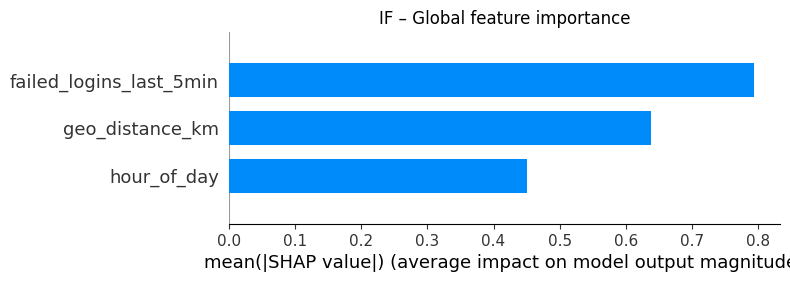

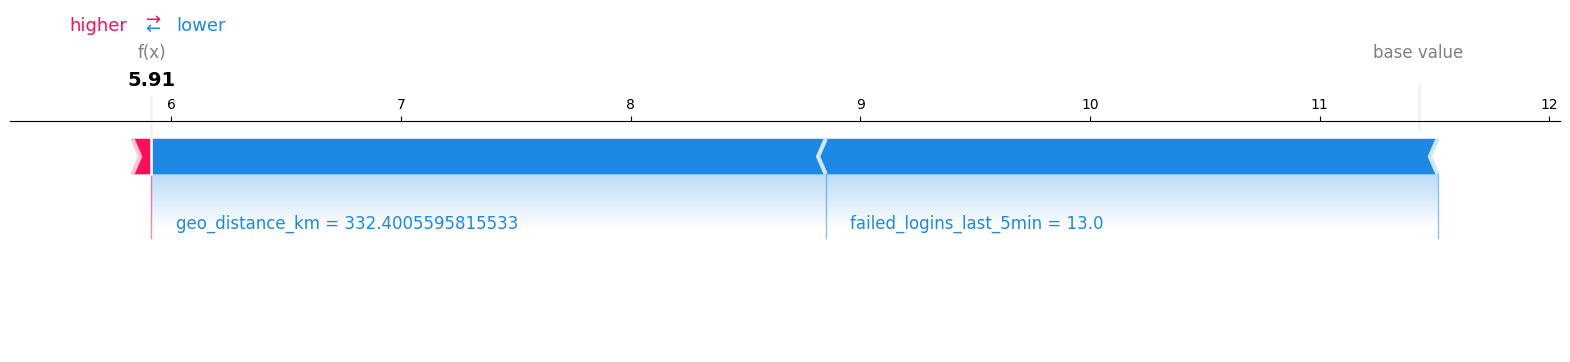

In [40]:
# Train Isolation Forest
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=0)
iso.fit(X_scaled)

# Use TreeExplainer
explainer_if = shap.TreeExplainer(iso)
shap_values_if = explainer_if.shap_values(X_scaled)

# Global bar plot
shap.summary_plot(shap_values_if, df, plot_type="bar", show=False)
plt.title("IF – Global feature importance")

# Explain a single suspicious record (index -1, an anomaly)
idx = len(df)-1
print("Instance:", df.iloc[idx].to_dict())
shap.force_plot(explainer_if.expected_value, shap_values_if[idx], df.iloc[idx], matplotlib=True)


### Interpretation Guide – SHAP for Isolation Forest

**Global bar plot**

* **Ordering** – Longer bars = higher *mean absolute* impact on anomaly score.
* **Units** – Same scale as the raw IF `decision_function`; positive value means *toward normal*, negative means *toward anomaly*.
* **Take‑away** – Top‑ranked feature(s) are the primary drivers of anomalies across the whole dataset.

**Per‑instance force plot**

* **Grey base value** – Average IF score on the background sample (≈ “typical normal point”).
* **Red arrows** – Features *lowering* the score below the threshold ⇒ make the point look anomalous.
* **Blue arrows** – Features pushing the score up toward normal.
* **Additivity check** – Sum of all arrows + base value = final model score (Shapley property).

> **Insight for analysts**: Large red arrow on `failed_logins_last_5min` pinpoints excessive login failures as the actionable root‑cause of the alert.


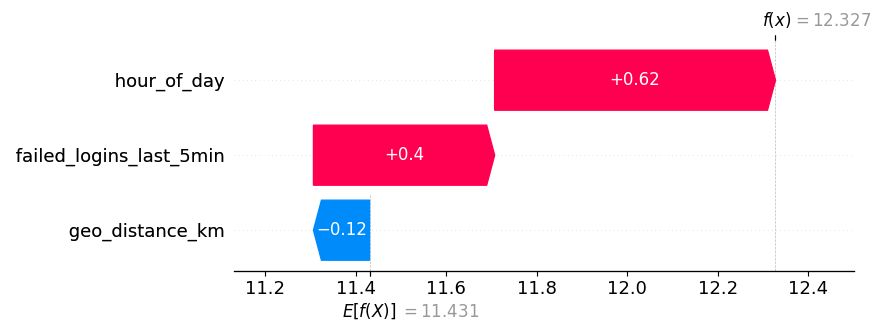

In [37]:

# Select the 3rd item
idx = 15
x_instance = df.iloc[idx]
shap_val_instance = shap_values_if[idx]

# Ensure expected value is scalar
base_val = explainer_if.expected_value[0] if isinstance(explainer_if.expected_value, (list, np.ndarray)) else explainer_if.expected_value

# Plot using SHAP legacy waterfall
shap.plots._waterfall.waterfall_legacy(
    base_val,
    shap_val_instance,
    feature_names=x_instance.index,
    features=x_instance.values
)

### 2b. SHAP for Autoencoder

Autoencoders aren’t tree‑based; we approximate explanations with **`KernelExplainer`** on the *reconstruction error* model.

Steps  
1. Wrap the AE to output reconstruction error per sample.  
2. Use a sample of background data (normal points) for Shapley baseline.  
3. Interpret SHAP values: features contributing most to *high* error caused the anomaly.


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


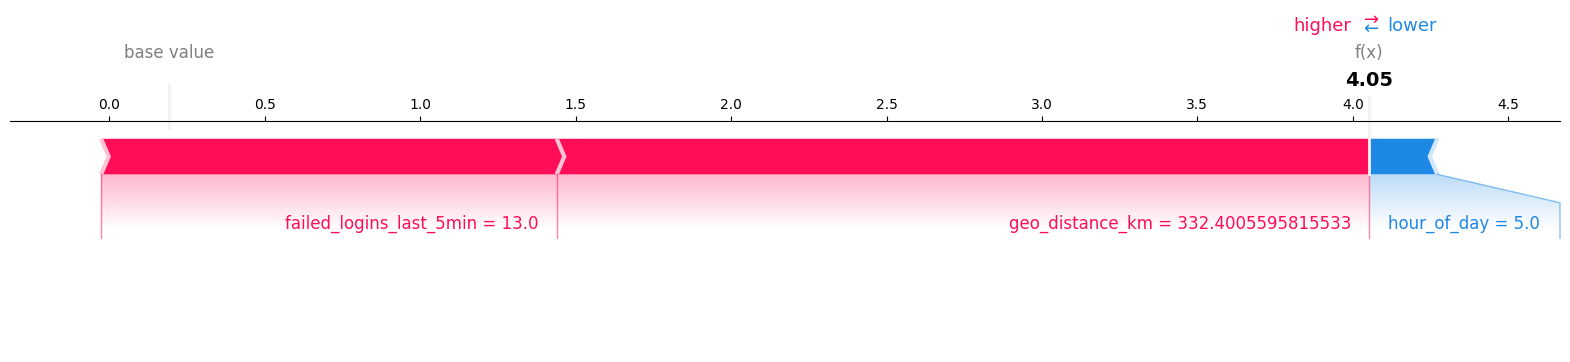

In [39]:
# Train tiny autoencoder on normal only
X_norm = X_scaled[y == 0]
inp = layers.Input(shape=(X_norm.shape[1],))
encoded = layers.Dense(10, activation='relu')(inp)
decoded = layers.Dense(X_norm.shape[1], activation='linear')(encoded)
ae = models.Model(inp, decoded)
ae.compile(optimizer='adam', loss='mse')
ae.fit(X_norm, X_norm, epochs=15, batch_size=64, verbose=0)

# Wrapper: output MSE scalar
import tensorflow as tf
def mse_model(x):
    recon = ae.predict(x, verbose=0)
    return np.mean(np.square(recon - x), axis=1)

# KernelExplainer (may be slow; use 100 background samples)
background = X_norm[np.random.choice(len(X_norm), 100, replace=False)]
explainer_ae = shap.KernelExplainer(mse_model, background)
# Explain one anomaly instance
sample = X_scaled[-1:].copy()
shap_values_ae = explainer_ae.shap_values(sample, nsamples=200)

# Visualise
shap.force_plot(explainer_ae.expected_value, shap_values_ae[0], df.iloc[[-1]], matplotlib=True)


### Interpretation Guide – SHAP for Autoencoder

**Why different?**  We explain the **reconstruction MSE** (higher ⇒ more anomalous).

* **Red arrows** – Features **increasing** MSE (push toward anomaly).
* **Blue arrows** – Features decreasing MSE.

**Caveats**

1. **Approximate** – KernelExplainer samples the feature space; small variations are expected.
2. **Scaling matters** – Ensure inputs are standardised; otherwise large‑scale features dominate SHAP magnitude.
3. **High‑dimensional data** – SHAP values may become diffuse. Consider PCA or local masking to focus on top‑k features.

> **Practical reading**: A dominant red arrow on `geo_distance_km` reveals the AE had never seen such a distance during training, hence cannot reconstruct it – that deviation generates high error.


## 3️⃣ Knowledge Check

1. **Trust & actionability** – How does a SHAP force plot help a security analyst decide next steps?  
2. **TreeExplainer vs KernelExplainer** – When would you prefer KernelExplainer even for a tree model?  
3. **Autoencoder explainability** – Why might SHAP values on raw reconstruction error be misleading in high‑dimensional data? Suggest a fix.  
4. **Regulatory** – Outline a GDPR‑compliant explanation you could generate for an Isolation Forest’s fraud flag.  
5. **Model improvement** – If SHAP reveals `hour_of_day` dominates anomaly scores but domain experts disagree, what steps would you take?


